In [1]:
import sys
import tqdm
import time
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import torch
import torch.nn.functional as F
from load_dataset import load
from classifier import NeuralNetwork, LogisticRegression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from sklearn import metrics, preprocessing
from datasketch import MinHashLSHEnsemble, MinHash, MinHashLSH
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
import json
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore') 

**Load Dataset**

In [3]:
dataset = 'german'
X_train, X_test, y_train, y_test = load(dataset)

**Parametric Model**

In [4]:
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Loss function** (Log loss for logistic regression)

In [6]:
# clf = NeuralNetwork(input_size=X_train.shape[-1])
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = SVM(input_size=X_train.shape[-1])
num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, LogisticRegression) or isinstance(clf, NeuralNetwork):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch

**Influence of points computed using ground truth**

In [7]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig, y_test):
    clf.fit(X_train, y_train, verbose=True)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig, y_test, 0)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
        delta_spd.append(delta_spd_i)

    return delta_spd

**Compute Accuracy** 

In [8]:
def computeAccuracy(y_true, y_pred):
    return np.sum((y_pred>0.5) == y_true)/len(y_pred)

**First-order derivative of loss function at z with respect to model parameters**

In [9]:
def del_L_del_theta_i(model, x, y_true, retain_graph=False):
    loss = loss_func(model, x, y_true)
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(loss, w, create_graph=True, retain_graph=retain_graph)

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [10]:
def del_f_del_theta_i(model, x, retain_graph=False):
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(model(torch.FloatTensor(x)), w, retain_graph=retain_graph)

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [11]:
def hvp(y, w, v):
    ''' Multiply the Hessians of y and w by v.'''
    # First backprop
    first_grads = grad(y, w, retain_graph=True, create_graph=True)

    # Elementwise products
    elemwise_products = 0
    for grad_elem, v_elem in zip(convert_grad_to_tensor(first_grads), v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    # Second backprop
    return_grads = grad(elemwise_products, w, create_graph=True)

    return return_grads

In [12]:
def hessian_one_point(model, x, y):
    x, y = torch.FloatTensor(x), torch.FloatTensor([y])
    loss = loss_func(model, x, y)
    params = [ p for p in model.parameters() if p.requires_grad ]
    first_grads = convert_grad_to_tensor(grad(loss, params, retain_graph=True, create_graph=True))
    hv = np.zeros((len(first_grads), len(first_grads)))
    for i in range(len(first_grads)):
        hv[i, :] = convert_grad_to_ndarray(grad(first_grads[i], params, create_graph=True)).ravel()
    return hv

In [13]:
# Compute multiplication of inverse hessian matrix and vector v
def s_test(model, xs, ys, v, hinv=None, damp=0.01, scale=25.0, r=-1, batch_size=-1, recursive=False, verbose=False):
    ''' Arguments:
        xs: list of data points
        ys: list of true labels corresponding to data points in xs
        damp: dampening factor
        scale: scaling factor
        r: number of iterations aka recursion depth
            should be enough so that the value stabilises.
        batch_size: number of instances in each batch in recursive approximation
        recursive: determine whether to recursively approximate hinv_v'''
    xs, ys = torch.FloatTensor(xs.copy()), torch.FloatTensor(ys.copy())
    n = len(xs)
    if recursive:
        hinv_v = copy.deepcopy(v)
        if verbose:
            print('Computing s_test...')
            tbar = tqdm.tqdm(total=r)
        if (batch_size == -1):  # default
            batch_size = 10
        if (r == -1):
            r = n // batch_size + 1
        sample = np.random.choice(range(n), r*batch_size, replace=True)
        for i in range(r):
            sample_idx = sample[i*batch_size:(i+1)*batch_size]
            x, y = xs[sample_idx], ys[sample_idx]
            loss = loss_func(model, x, y)
            params = [ p for p in model.parameters() if p.requires_grad ]
            hv = convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_v)))
            # Recursively caclulate h_estimate
            hinv_v = v + (1 - damp) * hinv_v - hv / scale
            if verbose:
                tbar.update(1)
    else:
        if hinv is None:
            hinv = np.linalg.pinv(np.sum(hessian_all_points, axis=0))
        scale = 1.0
        hinv_v = np.matmul(hinv, v)

    return hinv_v / scale

**Metrics: Initial state**

In [31]:
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = NeuralNetwork(input_size=X_train.shape[-1])
# clf = SVM(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.055140464566648006
Initial TPR parity:  -0.047411146437014495
Initial predictive parity:  -0.11142123176786023
Initial loss:  0.5719693645840669
Initial accuracy:  0.75


In [ ]:
hessian_all_points = []
# tbar = tqdm.tqdm(total=len(X_train))
total_time = 0
for i in range(len(X_train)):
    t0 = time.time()
    hessian_all_points.append(hessian_one_point(clf, X_train[i], y_train[i])/len(X_train))
    total_time += time.time()-t0
#     tbar.update(1)

In [34]:
total_time

16.719489574432373

**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [35]:
del_L_del_theta = []
for i in range(int(len(X_train))):
    gradient = convert_grad_to_ndarray(del_L_del_theta_i(clf, X_train[i], int(y_train[i])))
    while np.sum(np.isnan(gradient))>0:
        gradient = convert_grad_to_ndarray(del_L_del_theta_i(clf, X_train[i], int(y_train[i])))
    del_L_del_theta.append(gradient)

*Select delta fairness function depending on selected metric*

In [36]:
metric = 0
if metric == 0:
    v1 = del_spd_del_theta(clf, X_test_orig, X_test, dataset)
elif metric == 1:
    v1 = del_tpr_parity_del_theta(clf, X_test_orig, X_test, y_test, dataset)
elif metric == 2:
    v1 = del_predictive_parity_del_theta(clf, X_test_orig, X_test, y_test, dataset)

In [37]:
hinv = np.linalg.pinv(np.sum(hessian_all_points, axis=0))
hinv_v = s_test(clf, X_train, y_train, v1, hinv=hinv, verbose=False)

**First-order influence computation**

In [38]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf)
    return infs

In [39]:
def first_order_group_influence(U, del_L_del_theta):
    infs = []
    u = len(U)
    n = len(X_train)
    for i in range(u):
        idx = U[i]
        inf = -np.dot(del_L_del_theta[idx].transpose(), hinv)
        inf *= -1/n
        infs.append(inf)
    return np.sum(infs, axis=0)

**Second-order influence computation for a group of points in subset U**

In [40]:
def second_order_influence(model, X_train, y_train, U, del_L_del_theta, r=-1, verbose=False):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_sum = np.sum([del_L_del_theta[i] for i in U], axis=0)
    hinv_del_L_del_theta= s_test(model, X_train, y_train, del_L_del_theta_sum, hinv=hinv)
    hessian_U_hinv_del_L_del_theta = np.zeros((num_params,))
    for i in range(u):
        idx = U[i]
        x, y = torch.FloatTensor(X_train[idx]), torch.FloatTensor([y_train[idx]])
        loss = loss_func(model, x, y)
        params = [ p for p in model.parameters() if p.requires_grad ]
        hessian_U_hinv_del_L_del_theta += convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_del_L_del_theta)))

    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * s_test(model, X_train, y_train, hessian_U_hinv_del_L_del_theta, hinv=hinv)
    sum_term = term1 + term2
    return sum_term

In [41]:
def second_order_group_influence(U, del_L_del_theta):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_sum = np.sum([del_L_del_theta[i] for i in U], axis=0)
    hinv_del_L_del_theta= np.matmul(hinv, del_L_del_theta_sum)
    hessian_U_hinv_del_L_del_theta = np.zeros((num_params,))
    for i in range(u):
        idx = U[i]
        hessian_U_hinv_del_L_del_theta += np.matmul(hessian_all_points[idx], hinv_del_L_del_theta)

    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * np.matmul(hinv, hessian_U_hinv_del_L_del_theta)
    sum_term = (term1 + term2*len(X_train))
    return sum_term

**First-order influence of each training data point**

In [42]:
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

**Fairness: Ground-truth subset influence vs. computed subset influences: Coherent subset** 

(by coherent, we mean group of data points that share some properties)

***NOTE:*** The retraining of the clf would cause the change in model parameters and thus lead to the change of gradients, so in this part, we first acquire all the first- and second-order influence functions together based on the original model. After all the influence functions are calculated, we retrain the model corresponding to different removed coherent subset of data and get the ground truth.

In [44]:
alpha_f_lower = (-0.01) * (spd_0)
alpha_f_upper = -spd_0
del_f_threshold = (0.1) * spd_0
support = 0.03 # Do not consider extremely small patterns
support_small = 0.3 # For small patterns, 2nd-order estimation is quite accurate
del_f_threshold_small = (-0.1) * (spd_0)
print("alpha_f_lower:", alpha_f_lower)
print("alpha_f_upper:", alpha_f_upper)
print("del_f_threshold:", del_f_threshold)
print("support_small:", support_small)
print("del_f_threshold_small:", del_f_threshold_small)

alpha_f_lower: 0.00055140464566648
alpha_f_upper: 0.055140464566648006
del_f_threshold: -0.005514046456664801
support_small: 0.3
del_f_threshold_small: 0.005514046456664801


In [90]:
time_gt = []
time_first = []
time_second = []
rep = 1

In [91]:
for _ in range(rep):
    # Get the original model
#     clf = NeuralNetwork(input_size=X_train.shape[-1])
    clf = LogisticRegression(input_size=X_train.shape[-1])
#     clf = SVM(input_size=X_train.shape[-1])
    clf.fit(X_train, y_train)

    attributes = []
    attributeValues = []
    first_order_influences = []
    second_order_influences = []
    fractionRows = []

    v1_orig = v1
    for col in X_train_orig.columns:
        if dataset == 'german':
            if "purpose" in col or "housing" in col: #dummy variables purpose=0 doesn't make sense
                vals = [1]
            else:
                vals = X_train_orig[col].unique()
        elif dataset == 'adult':
            continuous_cols = ['age', 'education.num', 'hours',]
            if col in continuous_cols:
                vals = X_train_orig[col].unique()
            else:
                vals = [1]
        elif dataset == 'compas':
            vals = X_train_orig[col].unique()
        else:
            raise NotImplementedError
        for val in vals:
            idx = X_train_orig[X_train_orig[col] == val].index 
            
            if (len(idx)/len(X_train) > support):  
                X = np.delete(X_train, idx, 0)
                y = y_train.drop(index=idx, inplace=False)
                if len(y.unique()) > 1:
                    idx = X_train_orig[X_train_orig[col] == val].index 

                    # First-order subset influence
                    t0 = time.time()
                    params_f_1 = first_order_group_influence(idx, del_L_del_theta)
                    del_f_1 = np.dot(v1.transpose(), params_f_1)
                    time_first.append(time.time()-t0)

                    # Second-order subset influence
                    t0 = time.time()
                    params_f_2 = second_order_group_influence(idx, del_L_del_theta)
                    del_f_2 = np.dot(v1.transpose(), params_f_2)
                    time_second.append(time.time()-t0)

                    attributes.append(col)
                    attributeValues.append(val)
                    first_order_influences.append(del_f_1)
                    second_order_influences.append(del_f_2)
                    fractionRows.append(len(idx)/len(X_train)*100)

In [92]:
for _ in range(rep):
    gt_influences = []
    for col in X_train_orig.columns:
        if dataset == 'german':
            if "purpose" in col or "housing" in col: #dummy variables purpose=0 doesn't make sense
                vals = [1]
            else:
                vals = X_train_orig[col].unique()
        elif dataset == 'adult':
            continuous_cols = ['age', 'education.num', 'hours',]
            if col in continuous_cols:
                vals = X_train_orig[col].unique()
            else:
                vals = [1]
        elif dataset == 'compas':
            vals = X_train_orig[col].unique()
        else:
            raise NotImplementedError
        for val in vals:
            idx = X_train_orig[X_train_orig[col] == val].index 
            
            if (len(idx)/len(X_train) > support):  
                X = np.delete(X_train, idx, 0)
                y = y_train.drop(index=idx, inplace=False)
                if len(y.unique()) > 1:
                    # Ground truth subset influence
                    t0 = time.time()
                    clf.fit(np.array(X), np.array(y))
                    y_pred = clf.predict_proba(np.array(X_test))
                    if metric == 0:
                        inf_gt = computeFairness(y_pred, X_test_orig, y_test, 0, dataset) - spd_0
                    elif metric == 1:
                        inf_gt = computeFairness(y_pred, X_test_orig, y_test, 1, dataset) - tpr_parity_0
                    elif metric == 2:
                        inf_gt = computeFairness(y_pred, X_test_orig, y_test, 2, dataset) - predictive_parity_0
                    time_gt.append(time.time()-t0)
                    accuracy = computeAccuracy(y_test, y_pred)
                    gt_influences.append(inf_gt)

In [49]:
expl = [attributes, attributeValues, first_order_influences, second_order_influences, gt_influences, fractionRows]
expl = (np.array(expl).T).tolist()

explanations = pd.DataFrame(expl, columns=["attributes", "attributeValues", "first_order_influences", "second_order_influences", "gt_influences", "fractionRows"])
explanations['second_order_influences'] = explanations['second_order_influences'].astype(float)
explanations['first_order_influences'] = explanations['first_order_influences'].astype(float)
explanations['gt_influences'] = explanations['gt_influences'].astype(float)
explanations['fractionRows'] = explanations['fractionRows'].astype(float)

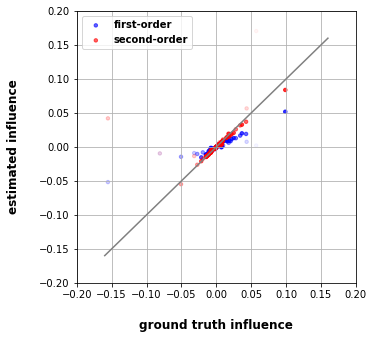

In [50]:
lim = .2
plt.figure(figsize=(5,5))
xs = (np.arange(31)-15)/15*lim*0.8
ys = xs
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.plot(xs, ys, 'grey')

# RGBA
color_first = np.zeros((len(gt_influences), 4))
color_first[:, 2] = 1.0
color_first[:, 3] = 1-np.array(fractionRows)/100
color_second = np.zeros((len(gt_influences), 4))
color_second[:, 0] = 1.0
color_second[:, 3] = 1-np.array(fractionRows)/100

plt.scatter(gt_influences, first_order_influences, s=12, color=color_first, label='first-order')
plt.scatter(gt_influences, second_order_influences, s=12, color=color_second, label='second-order')
plt.ylabel('estimated influence\n', fontsize=12, fontweight='bold')
plt.xlabel('\nground truth influence', fontsize=12, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})
plt.grid()
plt.savefig('infs.png')

In [51]:
candidates = explanations[(explanations["second_order_influences"] > alpha_f_lower) 
                           & (explanations["second_order_influences"] < alpha_f_upper)]
candidates = copy.deepcopy(explanations)
candidates.loc[:, 'score'] = candidates.loc[:, 'second_order_influences']*100/candidates.loc[:, 'fractionRows']
# display(candidates)

In [52]:
%%time
candidates_all = []

# Generating 1-candidates
candidates_1 = []
for i in range(len(candidates)):
    candidate = []
    candidate_i = candidates.iloc[i]
    if ((candidate_i["fractionRows"] > support_small) or
       ((candidate_i["fractionRows"] > support) & (candidate_i["second_order_influences"] > del_f_threshold))
       ):
        attr_i = candidate_i["attributes"]
        val_i = str(candidate_i["attributeValues"])
        predicates = []
        predicates.insert(0, attr_i + '=' + str(val_i))
        candidate.insert(0, predicates)
        candidate.insert(1, candidate_i["fractionRows"])
        candidate.insert(2, candidate_i["score"])
        candidate.insert(3, candidate_i["second_order_influences"])
        candidates_1.insert(i, candidate)
print("Generated: ", len(candidates_1), " 1-candidates")
candidates_1.sort()

for i in range(len(candidates_1)):
    if (float(candidates_1[i][2]) > support): # if score > top-k, keep in candidates, not otherwise
        candidates_all.insert(len(candidates_all), candidates_1[i])
    
# Generating 2-candidates
candidates_2 = []
for i in range(len(candidates_1)):
    attr_i = candidates_1[i][0][0].split("=")[0]
    val_i = int(candidates_1[i][0][0].split("=")[1])
    for j in range(i):
        # merge two candidates
        attr_j = candidates_1[j][0][0].split("=")[0]
        val_j = int(candidates_1[j][0][0].split("=")[1])
        
        if (attr_i != attr_j):
            idx = X_train_orig[(X_train_orig[attr_i] == val_i) &
                              (X_train_orig[attr_j] == val_j)].index 
            
            idx_i = X_train_orig[(X_train_orig[attr_i] == val_i)].index 
            idx_j = X_train_orig[(X_train_orig[attr_j] == val_j)].index 
            fractionRows = len(idx)/len(X_train) * 100
            isCompact = True
            if (len(idx) == min(len(idx_i), len(idx_j))): # pattern is not compact if intersection equals one of its parents
                isCompact = False
            if (fractionRows/100 > support):
                X = np.delete(X_train, idx, 0)
                y = y_train.drop(index=idx, inplace=False)

                size_hvp = 1
                params_f_2 = second_order_group_influence(idx, del_L_del_theta)
                del_f_2 = np.dot(v1.transpose(), params_f_2)
                
                score = del_f_2 * 100/fractionRows
                if (((score > candidates_1[i][2]) & (score > candidates_1[j][2]))
                   or (fractionRows/100 > support_small)):
                        candidate = []
                        predicates = []
                        predicates.insert(0, attr_i + '=' + str(val_i))
                        predicates.insert(1, attr_j + '=' + str(val_j))
                        candidate.insert(0, sorted(predicates, key=itemgetter(0)))                        
                        candidate.insert(1, len(idx)*100/len(X_train))
                        candidate.insert(2, score)
                        candidate.insert(3, del_f_2)
                        candidates_2.insert(len(candidates_2), candidate)  
                        if (isCompact):
                            candidates_all.insert(len(candidates_all), candidate)
print("Generated: ", len(candidates_2), " 2-candidates")
candidates_2.sort()

# Recursively generating the rest
candidates_L_1 = copy.deepcopy(candidates_2)
iter=2
while((len(candidates_L_1) > 0) & (iter < 4)):
    print("Generated: ", iter)    
    candidates_L = []
    for i in range(len(candidates_L_1)):
        candidate_i = candidates_L_1[i][0]
        for j in range(i):
            candidate_j = candidates_L_1[j][0]
            # if L-1 lists intersect
            intersect_candidates = set(candidate_i).intersection(candidate_j)
            if (len(intersect_candidates) == iter - 1):
                setminus_i = list(set(candidate_i) - intersect_candidates)[0].split("=")
                setminus_j = list(set(candidate_j) - intersect_candidates)[0].split("=")
                attr_i = setminus_i[0]
                val_i = int(setminus_i[1])
                attr_j = setminus_j[0]
                val_j = int(setminus_j[1])
                if (attr_i != attr_j):
                    # merge to get L list
                    merged_candidate = list(set(candidate_i + candidate_j))

                    idx_i_j = pd.Index(list(range(len(X_train_orig))))
                    for k in range(len(intersect_candidates)):
                        attr = list(intersect_candidates)[k].split("=")[0]
                        val = int(list(intersect_candidates)[k].split("=")[1])
                        idx_i_j = idx_i_j.intersection(X_train_orig[(X_train_orig[attr] == val)].index)
                    
                    idx_i = idx_i_j.intersection(X_train_orig[(X_train_orig[attr_i] == val_i)].index)
                    idx_j = idx_i_j.intersection(X_train_orig[(X_train_orig[attr_j] == val_j)].index)                    
                    idx = idx_i.intersection(X_train_orig[(X_train_orig[attr_j] == val_j)].index) # merged

                    fractionRows = len(idx)/len(X_train) * 100
                    isCompact = True
                    if (len(idx) == min(len(idx_i), len(idx_j))): # pattern is not compact if intersection equals one of its parents
                        isCompact = False
                    if (fractionRows/100 > support):
                        X = np.delete(X_train, idx, 0)
                        y = y_train.drop(index=idx, inplace=False)

                        size_hvp = 1
                        params_f_2 = second_order_group_influence(idx, del_L_del_theta)
                        del_f_2 = np.dot(v1.transpose(), params_f_2)
                        score = del_f_2 * 100/fractionRows
                        if (((score > candidates_L_1[i][2]) & (score > candidates_L_1[j][2])) or 
                           (fractionRows > support_small)):
                            candidate = []
                            candidate.insert(0, sorted(merged_candidate, key=itemgetter(0)))                        
                            candidate.insert(1, fractionRows)
                            candidate.insert(2, del_f_2*len(X_train)/len(idx))
                            candidate.insert(3, del_f_2)
                            if (candidate not in candidates_L):
                                candidates_L.insert(len(candidates_L), candidate)
                                if (isCompact):
                                    candidates_all.insert(len(candidates_all), candidate)
    print("Generated:", len(candidates_L), " ", str(iter+1), "-candidates")
    candidates_L_1 = copy.deepcopy(candidates_L)
    candidates_L_1.sort()
    iter += 1

Generated:  67  1-candidates
Generated:  392  2-candidates
Generated:  2
Generated: 2664   3 -candidates
Generated:  3
Generated: 14696   4 -candidates
CPU times: user 8min 5s, sys: 2.73 s, total: 8min 8s
Wall time: 8min 20s


In [53]:
candidates_support_3_compact = copy.deepcopy(candidates_all)
print(len(candidates_support_3_compact))
candidates_df_3_compact = pd.DataFrame(candidates_support_3_compact, columns=["predicates","support","score","2nd-inf"])
candidates_df_3_compact = candidates_df_3_compact[candidates_df_3_compact["support"] < 20].sort_values(by=['2nd-inf'], ascending=False)
# display(candidates_df_3_compact)
# display(candidates_df_3_compact[candidates_df_3_compact["support"] < 20].sort_values(by=['2nd-inf'], ascending=False).head(5))

17441


**Containment-based filtering**

In [54]:
def get_subset(X_train_orig, explanation):
    subset = X_train_orig.copy()
    for predicate in explanation:
#         print(predicate)
        attr = predicate.split("=")[0].strip(' ')
        val = int(predicate.split("=")[1].strip(' '))
        subset = subset[subset[attr]==val]
    return subset.index

class Topk:
    '''
        top explanations: explanation -> (minhash, set_index, score)
    '''
    def __init__(self, method='lsh', init_df=X_test_orig, init_explanations=[], threshold=0.75, k=5, num_perm=128):
        self.method = method
        self.num_perm = num_perm
        if method == 'lshensemble':
            self.index = MinHashLSHEnsemble(threshold=threshold, num_perm=num_perm)
            hashed_explanations = []
            for explanation, score in init_explanations:
                s = get_subset(init_df, explanation)
                m = MinHash(num_perm=num_perm)
                explanation_json = json.dumps(explanation)
                for d in s:
                    m.update(str(d).encode('utf8'))
                hashed_explanations.append((explanation_json, m, len(s)))
            self.index.index(hashed_explanations)
#             raise NotImplementedError
        elif method == 'lsh':
            self.index = MinHashLSH(threshold=threshold, num_perm=num_perm, params=[64, self.num_perm//64])
            for explanation, score in init_explanations:
                s = get_subset(init_df, explanation)
                m = MinHash(num_perm=num_perm)
                explanation_json = json.dumps(explanation)
                for d in s:
                    m.update(str(d).encode('utf8'))
                self.index.insert(explanation_json, m)
#             raise NotImplementedError

        self.top_explanations = dict()
        self.k = k
        self.threshold = threshold
        self.min_score = -100
        self.min_score_explanation =None
    
    def _update_min(self, new_explanation, new_score):
        if len(self.top_explanations) > 0:
            for explanation, t in self.top_explanations.items():
                if t[2] < new_score:
                    new_score = t[2]
                    new_explanation = explanation
        self.min_score = new_score
        self.min_score_explanation = new_explanation
        
    def _containment(self, x, q):
        return len(x & q)/len(q)
            
    def update(self, df, explanation, score):
        if (len(self.top_explanations) < self.k) or (score > self.min_score):
            s = get_subset(df, explanation)
            m = MinHash(num_perm=self.num_perm)
            explanation = json.dumps(explanation)
            for d in s:
                m.update(str(d).encode('utf8'))

            if self.method == 'lshensemble':
                q_result = set(self.index.query(m, len(s))).intersection(set(self.top_explanations.keys()))
            elif self.method == 'lsh':
                q_result = set(self.index.query(m)).intersection(set(self.top_explanations.keys()))
            elif self.method == 'containment':
                q_result = set()
                for k, v in self.top_explanations.items():
                    if self._containment(v[1], s) > self.threshold:
                        q_result.add(k)

            if len(q_result)==0:
                if len(self.top_explanations) <= self.k-1:
                    self._update_min(explanation, score)
                    self.top_explanations[explanation] = (m, s, score)
                    return 0
                else:
                    del self.top_explanations[self.min_score_explanation]
                    self._update_min(explanation, score)
                    self.top_explanations[explanation] = (m, s, score)
                    return 0
            else:
                q_scores = [self.top_explanations[explanation][2] for explanation in q_result]
                if max(q_scores) < score:
                    for explanation in q_result:
                        del self.top_explanations[explanation]
                    self._update_min(explanation, score)
                    self.top_explanations[explanation] = (m, s, score)
#                     print('Inserted')
                    return 0
        return -1

In [55]:
sorted_df = candidates_df_3_compact.sort_values(by=['score'], ascending=False).copy()

topk = Topk(method='containment', threshold=0.2, k=10)
for row_idx in range(len(sorted_df)):
    row = sorted_df.iloc[row_idx]
    explanation, score = row[0], row[2]
    topk.update(X_train_orig, explanation, score)
    if len(topk.top_explanations) == topk.k:
        break

In [56]:
explanations = list(topk.top_explanations.keys())
idxs = [v[1] for v in topk.top_explanations.values()]
supports = list()
scores = list()
infs = list()
for e in explanations:
    condition = candidates_df_3_compact.predicates.apply(lambda x: x==json.loads(e))
    supports.append(float(candidates_df_3_compact[condition]['support']))
    scores.append(float(candidates_df_3_compact[condition]['score']))
    infs.append(float(candidates_df_3_compact[condition]['2nd-inf']))

expl = [explanations, supports, scores, infs]
expl = (np.array(expl).T).tolist()

explanations = pd.DataFrame(expl, columns=["explanations", "support", "score", "2nd-inf"])
explanations['score'] = explanations['score'].astype(float)
explanations['support'] = explanations['support'].astype(float)
if metric == 0:
    explanations['2nd-inf'] = explanations['2nd-inf'].astype(float)/(-spd_0)
elif metric == 1:
    explanations['2nd-inf'] = explanations['2nd-inf'].astype(float)/(-tpr_parity_0)
elif metric == 2:
    explanations['2nd-inf'] = explanations['2nd-inf'].astype(float)/(-predictive_parity_0)
pd.set_option('max_colwidth', 100)
explanations.sort_values(by=['score'], ascending=False)


,explanations,support,score,2nd-inf
0,"[""age=1"", ""gender=0"", ""housing_A152=1""]",3.500,0.768868,0.488034
1,"[""age=1"", ""credit_hist=0"", ""credit_amt=0"", ""gender=1""]",3.375,0.656537,0.401849
2,"[""age=1"", ""status=3"", ""telephone=1""]",3.750,0.576817,0.392282
3,"[""age=1"", ""credit_amt=1"", ""num_liable=1"", ""savings=0""]",3.125,0.488182,0.276670
4,"[""age=1"", ""foreign_worker=1"", ""num_liable=1"", ""residence=4""]",11.000,0.440223,0.878202
5,"[""credit_hist=2"", ""employment=4"", ""install_rate=4"", ""job=2""]",3.375,0.311981,0.190955
6,"[""foreign_worker=1"", ""gender=1"", ""install_plans=1"", ""property=0""]",3.500,0.282771,0.179487
7,"[""gender=0"", ""install_rate=4"", ""install_plans=0"", ""status=0""]",4.250,0.244389,0.188365
8,"[""employment=4"", ""foreign_worker=1"", ""status=3"", ""savings=0""]",3.875,0.237609,0.166980
9,"[""install_rate=4"", ""num_credits=1"", ""savings=4"", ""telephone=0""]",3.500,0.235172,0.149274


In [74]:
lrs = [0.01, 0.05, 0.1, 0.5, 1, 3, 5, 10]
lr = lrs[4]

In [75]:
time_gd = []
for _ in range(rep):
    gd_influences = []
    for col in X_train_orig.columns:
        if dataset == 'german':
            if "purpose" in col or "housing" in col: #dummy variables purpose=0 doesn't make sense
                vals = [1]
            else:
                vals = X_train_orig[col].unique()
        elif dataset == 'adult':
            continuous_cols = ['age', 'education.num', 'hours',]
            if col in continuous_cols:
                vals = X_train_orig[col].unique()
            else:
                vals = [1]
        elif dataset == 'compas':
            vals = X_train_orig[col].unique()
        else:
            raise NotImplementedError

        for val in vals:
            idx = X_train_orig[X_train_orig[col] == val].index 
            
            if (len(idx)/len(X_train) > support):  
                X = np.delete(X_train, idx, 0)
                y = y_train.drop(index=idx, inplace=False)
                if len(y.unique()) > 1:                # Ground truth subset influence
                    clf_new = LogisticRegression(input_size=X_train.shape[-1])
#                     clf_new = SVM(input_size=X_train.shape[-1])
#                     clf_new = NeuralNetwork(input_size=X_train.shape[-1])
                    clf_new.fit(X_train, y_train)
                    t0 = time.time()
                    optimizer = torch.optim.SGD(clf_new.parameters(), lr=lr)
                    clf_new.train()
                    loss = loss_func(clf_new, np.array(X), np.array(y))
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    y_pred = clf_new.predict_proba(np.array(X_test))
                    if metric == 0:
                        inf_gd = computeFairness(y_pred, X_test_orig, y_test, 0, dataset) - spd_0
                    elif metric == 1:
                        inf_gd = computeFairness(y_pred, X_test_orig, y_test, 1, dataset) - tpr_parity_0
                    elif metric == 2:
                        inf_gd = computeFairness(y_pred, X_test_orig, y_test, 2, dataset) - predictive_parity_0
                    time_gd.append(time.time()-t0)
                    accuracy = computeAccuracy(y_test, y_pred)
                    gd_influences.append(inf_gd)

In [93]:
time_gt_ave = []
time_second_ave = []
time_first_ave = []
time_gd_ave = []

l = len(time_gt)//rep
for i in range(l):
    time_gt_ave.append(np.average([time_gt[i+j*l] for j in range(rep)]))
    time_second_ave.append(np.average([time_second[i+j*l] for j in range(rep)]))
    time_first_ave.append(np.average([time_first[i+j*l] for j in range(rep)]))
    time_gd_ave.append(np.average([time_gd[i+j*l] for j in range(rep)]))

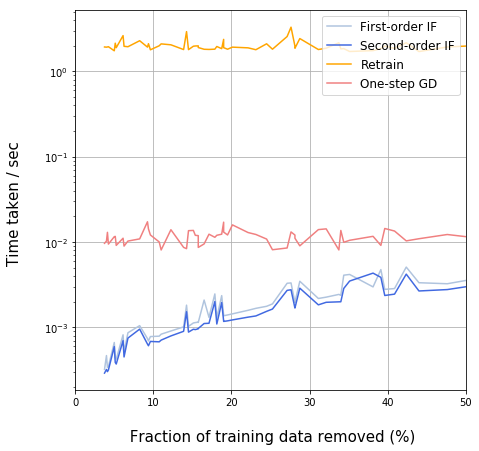

In [94]:
plt.figure(figsize=(7,7))
# plt.subplot(131)
sorted_idx = pd.Series(fractionRows).sort_values(ascending=True).index
first_xs = []
first_ys = []
for idx in sorted_idx:
    first_xs.append(fractionRows[idx])
    first_ys.append(time_first_ave[idx])
plt.plot(first_xs, first_ys, '-', c='lightsteelblue', label='First-order IF')

# plt.subplot(132)
second_xs = []
second_ys = []
for idx in sorted_idx:
    second_xs.append(fractionRows[idx])
    second_ys.append(time_second_ave[idx])
plt.plot(second_xs, second_ys, '-', c='royalblue', label='Second-order IF')

'''********************** re-training would be much much slower **********************'''
# plt.subplot(133)
gt_xs = []
gt_ys = []
for idx in sorted_idx:
    gt_xs.append(fractionRows[idx])
    gt_ys.append(time_gt_ave[idx])
plt.plot(gt_xs, gt_ys, '-', c='orange', label='Retrain')

gd_xs = []
gd_ys = []
for idx in sorted_idx:
    gd_xs.append(fractionRows[idx])
    gd_ys.append(time_gd_ave[idx])
plt.plot(gd_xs, gd_ys, '-', c='lightcoral', label='One-step GD')

plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.xlabel('\n Fraction of training data removed (%)', fontsize=15)
plt.ylabel('Time taken / sec \n', fontsize=15)
plt.yscale("log")
plt.xlim(0, 50)
# plt.show()
plt.savefig('time.png')

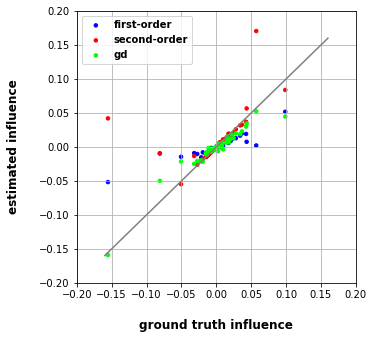

In [81]:
lim = .2
plt.figure(figsize=(5,5))
xs = (np.arange(31)-15)/15*lim*0.8
ys = xs
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.plot(xs, ys, 'grey')

# RGBA
color_first = np.zeros((len(gt_influences), 4))
color_first[:, 2] = 1.0
color_first[:, 3] = 1-np.array(fractionRows)/100
color_second = np.zeros((len(gt_influences), 4))
color_second[:, 0] = 1.0
color_second[:, 3] = 1-np.array(fractionRows)/100

color_gd = np.zeros((len(gt_influences), 4))
color_gd[:, 1] = 1.0
color_gd[:, 3] = 1-np.array(fractionRows)/100

plt.scatter(gt_influences, first_order_influences, s=12, color=color_first, label='first-order')
plt.scatter(gt_influences, second_order_influences, s=12, color=color_second, label='second-order')
plt.scatter(gt_influences, gd_influences, s=12, color=color_gd, label='gd')
plt.ylabel('estimated influence\n', fontsize=12, fontweight='bold')
plt.xlabel('\nground truth influence', fontsize=12, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})
plt.grid()
# plt.savefig('infs.png')